In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima.arima import ndiffs
from sklearn.model_selection import train_test_split
from pmdarima.metrics import smape
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
df = pd.read_csv("META_2021-11-01_2023-10-31.csv", parse_dates=True)
close = df["Close"]

In [6]:
train_data, test_data = train_test_split(close, test_size=0.1, shuffle=False)

kpss_diffs = ndiffs(train_data, alpha=0.05, test="kpss", max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test="adf", max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 2


https://alkaline-ml.com/pmdarima/usecases/stocks.html

In [7]:
auto = pm.auto_arima(
    train_data,
    d=2,
    seasonal=False,
    suppress_warnings=True,
    trace=True,
    max_p=8,
    max_q=8,
)

auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3384.704, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3248.214, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3382.705, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=3211.358, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3195.607, Time=0.12 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=3172.290, Time=0.11 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=3158.156, Time=0.13 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=3143.597, Time=0.25 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=3142.746, Time=0.32 sec
 ARIMA(8,2,0)(0,0,0)[0] intercept   : AIC=3130.692, Time=0.33 sec
 ARIMA(8,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(7,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(8,2,0)(0,0,0)[0]             : AIC=3128.716, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  451
Model:               SARIMAX(8, 2, 1)   Log Likelihood               -1530.941
Date:                Thu, 21 Dec 2023   AIC                           3081.882
Time:                        14:02:22   BIC                           3122.952
Sample:                             0   HQIC                          3098.070
                                - 451                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0267      0.075     -0.355      0.723      -0.174       0.121
ar.L2          0.0040      0.052      0.075      0.940      -0.099       0.107
ar.L3         -0.0718      0.055     -1.315      0.188      -0.179       0.035
ar.L4         -0.1148      0.055     -2.082      0.037      -0.223      -0.007
ar.L5         -0.0315      0.058     -0.544      0.587      -0.145       0.082
ar.L6         -0.0262      0.046     -0.568      0.570      -0.117       0.064
ar.L7          0.0082      0.070      0.117      0.907      -0.129       0.146
ar.L8         -0.0836      0.081     -1.035      0.300      -0.242       0.075
ma.L1         -0.9826      0.016    -63.321      0.000      -1.013      -0.952
sigma2        53.1131      1.506     35.267      0.000      50.161      56.065
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             28024.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -2.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
model = pm.ARIMA(order=auto.order, suppress_warnings=True)
model = model.fit(train_data)


def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])


forecasts = []
confidence_intervals = []

for new_ob in test_data:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test_data, forecasts)}")
print(f"SMAPE: {smape(test_data, forecasts)}")
print(f"MAE: {mean_absolute_error(test_data, forecasts)}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_data, forecasts))}")
print(
    f"MAPE: {np.mean(np.abs(forecasts - test_data.values) / np.abs(test_data.values)) * 100}"
)
print(
    f"MASE: {np.mean(np.abs(forecasts - test_data.values) / np.std(test_data.values))}"
)

Mean squared error: 35.230944202155584
SMAPE: 1.6017641475675046
MAE: 4.875510853816148
RMSE: 5.935566038901057
MAPE: 1.6104889638833968
MASE: 0.4631261075875552


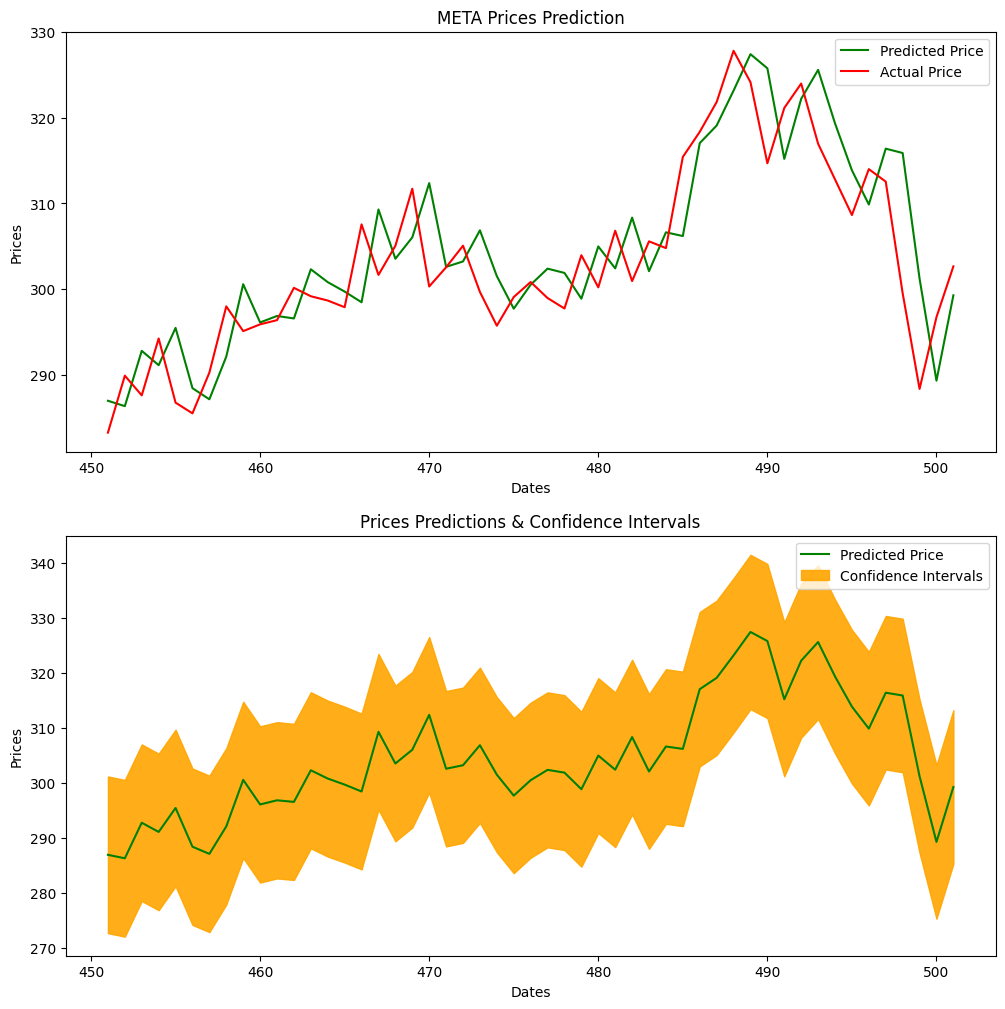

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

axes[0].plot(test_data.index, forecasts, color="green", label="Predicted Price")
axes[0].plot(test_data.index, test_data, color="red", label="Actual Price")
axes[0].set_title("META Prices Prediction")
axes[0].set_xlabel("Dates")
axes[0].set_ylabel("Prices")
axes[0].legend()

axes[1].plot(test_data.index, forecasts, color="green", label="Predicted Price")
axes[1].set_title("Prices Predictions & Confidence Intervals")
axes[1].set_xlabel("Dates")
axes[1].set_ylabel("Prices")
conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(
    test_data.index,
    conf_int[:, 0],
    conf_int[:, 1],
    alpha=0.9,
    color="orange",
    label="Confidence Intervals",
)
axes[1].legend()